# MaterialsCoord benchmarking – sensitivity to perturbation analysis

This notebook demonstrates how to use MaterialsCoord to benchmark the sensitivity of bonding algorithms to structural perturbations. Perturbations are introduced according the Einstein crystal test rig, in which site is perturbed so that the distribution around the equilibrium position yields a normal distribution for each Cartesian component.

The perturbation complies thus with the expectation for an Einstein crystal,
in which the potential is given by $V(\delta r) = 0.5 k_\mathrm{spring} \delta r^2$, where
$k_\mathrm{spring}$ denotes the spring constant with which the sites are tethered to
their equilibrium position, and $\delta r$ is the distance of the site under
consideration from its equilibrium position.

The MaterialsCoord `Benchmark` class accepts a `perturb_sigma` option, which is equal to $(k_\mathrm{B}T/k_\mathrm{spring})^{0.5}$.

*Written using:*
- MaterialsCoord==0.1.0

*Authors: Hillary Pan, Alex Ganose (10/12/19)*

---

First, lets initialize the near neighbor methods we are interested in.

In [1]:
from pymatgen.analysis.local_env import BrunnerNN_reciprocal, EconNN, JmolNN, \
                                        MinimumDistanceNN, MinimumOKeeffeNN, MinimumVIRENN, \
                                        VoronoiNN, CrystalNN

nn_methods = [
    BrunnerNN_reciprocal(), EconNN(tol=0.5), JmolNN(), CrystalNN(), VoronoiNN(tol=0.5),
    MinimumDistanceNN(), MinimumOKeeffeNN(), MinimumVIRENN()
]

Next, import the benchmark and choose which structures we are interested in.

In [2]:
from materialscoord.core import Benchmark

structure_groups = ["common_binaries", "elemental", "A2BX4", "ABX3", "ABX4"]

Choose the initial and final perturbation sigma values to include, as well as the number of steps inbetween.

In [3]:
import numpy as np

initial_sigma = 0
final_sigma = 0.2
nsteps = 100

sigmas = np.linspace(initial_sigma, final_sigma, nsteps)

Run the benchmark with the perturbation turned on. Note we have disabled symmetry so that each perturbed site is treated separately. Due to the absence of symmetry and the slow speed of `MinimumVIRENN`, this can take a long time (14 hours on a 2017 MacBook Pro).

In [4]:
from tqdm import tqdm_notebook

results = []
for sigma in tqdm_notebook(sigmas):
    bm = Benchmark.from_structure_group(structure_groups, perturb_sigma=sigma, symprec=None)
    sigma_scores = bm.score(nn_methods)
    results.append(sigma_scores.iloc[-1].values)

<ipython-input-4-9e2057c5afdc>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sigma in tqdm_notebook(sigmas):


KeyboardInterrupt: 

Finally, plot the results.

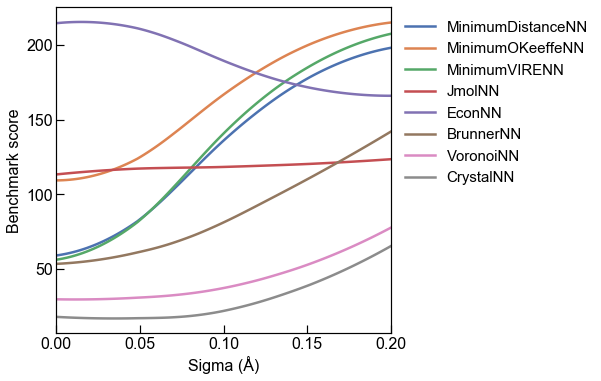

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
import os
from scipy.signal import savgol_filter
import seaborn as sns


plt_results = np.array(results).T

# define matplotlib style settings
style = {
    "font.sans-serif": ["Helvetica", "Arial"], "axes.labelsize": 16,
    "xtick.labelsize": 16, "ytick.labelsize": 16, "xtick.direction": "in",
    "ytick.direction": "in", "xtick.major.size": 8, "xtick.minor.size": 4,
    "ytick.major.size": 8, "ytick.minor.size": 4, "lines.linewidth": 2.5,
    "lines.markersize": 10, "axes.linewidth": 1.2, "xtick.major.width": 1.2,
    "xtick.minor.width": 1.2, "ytick.major.width": 1.2, "ytick.minor.width": 1.2,  
}

nn_method_mapping = {"BrunnerNN_reciprocal": "BrunnerNN"}
colors = sns.color_palette("deep")
order = [5, 6, 7, 2, 1, 0, 4, 3]

plt.style.use(style)
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

for i, x in enumerate(order):
    method = nn_methods[x]
    y_vals = plt_results[x]
    
    name = method.__class__.__name__
    c = colors[i]
    name = nn_method_mapping.get(name, name)
    
    # smooth the lines with a double pass through a savgol filter
    # more ideal would be to take averages accross multiple runs
    # but due to the time taken to generate the data this is impractical
    y_vals = savgol_filter(y_vals, 49, 2)
    y_vals = savgol_filter(y_vals, 49, 2)

    ax.plot(sigmas, y_vals, label=name, c=c)

ax.set(ylabel="Benchmark score", xlabel="Sigma (Å)")
ax.set_xlim((0, 0.2))

ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=15)
plt.savefig(os.path.join("plots", "perturbation-tolerance.pdf"), bbox_inches="tight")
plt.show()